The motivation for this python notebook is to test the Taylor expansion of the classical MSMF versus the basis decomposition done in DDFacet.

## Source simulation

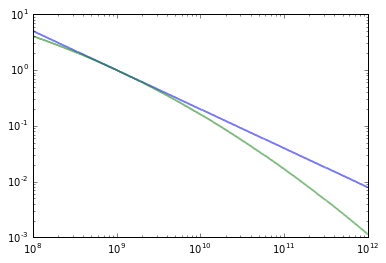

In [116]:
import numpy as np
import scipy.constants as sc
import scipy.interpolate as si
import matplotlib.pyplot as plt
%matplotlib inline

alpha=-0.7   # Spectral Index
beta=-0.0933   # Spectral Curvature
I0=1.
nu0=1e9
lambda0=sc.c/nu0


Nfreq=1000

freqstart=8
freqend=12

freq=np.logspace(freqstart,freqend,Nfreq)

spectrum=I0*(freq/nu0)**(alpha)
spectrum2=I0*(freq/nu0)**(alpha+beta*np.log10(freq/nu0))

plt.loglog(freq,spectrum,".",ms=0.5)
plt.loglog(freq,spectrum2,".",ms=0.5)


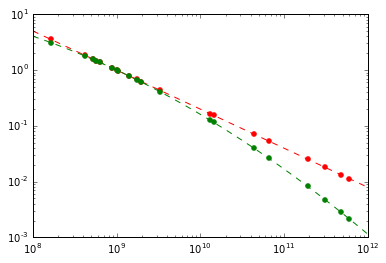

In [117]:
# prepare some samples of spectrum
Nsamples=20

randomindices=(np.random.rand(Nsamples)*1000).astype(int)
randomindices
sampledfreq=freq[randomindices]
sampledspectrum=spectrum[randomindices]
sampledspectrum2=spectrum2[randomindices]

plt.loglog(freq,spectrum,"r--",ms=0.5)
plt.loglog(sampledfreq,sampledspectrum,"r.",ms=10)
plt.loglog(freq,spectrum2,"g--",ms=0.5)
plt.loglog(sampledfreq,sampledspectrum2,"g.",ms=10)


## Polynomial fit

In [127]:
coefs = np.polynomial.polynomial.polyfit(np.log10(freq/nu0), np.log10(spectrum), 2)
print "Alpha = "+str(coefs[1])

Alpha = -0.7


In [128]:
coefs2 = np.polynomial.polynomial.polyfit(np.log10(freq/nu0), np.log10(spectrum2), 2)
print "Alpha = "+str(coefs2[1])
print "Beta = "+str(coefs2[2])

Alpha = -0.7
Beta = -0.0933


## Cyril Expansion